In [1]:
import os
from prometheus_client import Gauge
from prometheus_api_client import PrometheusConnect, MetricSnapshotDataFrame
from prometheus_api_client.utils import parse_datetime
from dotenv import load_dotenv
import pandas as pd
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5

load_dotenv()

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, SGDRegressor

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

import numpy as np

from joblib import dump, load
import warnings
# warnings.filterwarnings('ignore')

In [8]:
prom = PrometheusConnect(url=os.getenv('PROMETHEUS_URL'), disable_ssl=True)

start_time = parse_datetime('2022-05-11 07:50:07')
#end_time = parse_datetime("now")
end_time = parse_datetime('2022-05-11 10:47:07')
plot_time = str(parse_datetime("30m")).split('.')[0]
#label_config = {'host': 'localhost'}
#requests_seconds = MetricSnapshotDataFrame(prom.get_metric_range_data('nginx_vts_server_request_seconds', start_time=start_time, end_time=end_time, label_config=label_config, chunk_size=timedelta(seconds=15)))
#requests_seconds = MetricSnapshotDataFrame(prom.get_metric_range_data('btalert_requests_per_second', start_time=start_time, end_time=end_time, chunk_size=timedelta(seconds=15)))
requests_seconds = MetricSnapshotDataFrame(prom.get_metric_range_data('btalert_failed_requests_percent', start_time=start_time, end_time=end_time, chunk_size=timedelta(seconds=15)))

print(requests_seconds.head())
print(len(requests_seconds))

c:\users\denis\desktop\api6\btalert-ai\venv\lib\site-packages\dateparser\date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


                          __name__         instance                  job  \
0  btalert_failed_requests_percent  btalert-ai:5050  btalert-ai-exporter   
1  btalert_failed_requests_percent  btalert-ai:5050  btalert-ai-exporter   
2  btalert_failed_requests_percent  btalert-ai:5050  btalert-ai-exporter   
3  btalert_failed_requests_percent  btalert-ai:5050  btalert-ai-exporter   
4  btalert_failed_requests_percent  btalert-ai:5050  btalert-ai-exporter   

      timestamp value  
0  1.652266e+09     0  
1  1.652266e+09     0  
2  1.652266e+09     0  
3  1.652266e+09     0  
4  1.652266e+09     0  
691


In [76]:


req_dataframe = requests_seconds[['timestamp', 'value']].copy()
req_dataframe['timestamp'] = [datetime.fromtimestamp(timestamp) for timestamp in req_dataframe['timestamp']]
req_dataframe['value'] = [float(value) for value in req_dataframe['value']]

req_dataframe['timestamp'] = req_dataframe['timestamp'].astype('datetime64[s]')
req_dataframe = req_dataframe.set_index(req_dataframe['timestamp'])
#req_dataframe = req_dataframe.drop(columns='timestamp')

print(f'Number of rows with missing values: {req_dataframe.isnull().any(axis=1).mean()}')
req_dataframe = req_dataframe.asfreq(freq='15S', method='bfill')
print(f'Number of rows with missing values: {req_dataframe.isnull().any(axis=1).mean()}')
print(req_dataframe.head(10))

Number of rows with missing values: 0.0
Number of rows with missing values: 0.0
                              timestamp  value
timestamp                                     
2022-05-11 07:50:12 2022-05-11 07:50:12   0.00
2022-05-11 07:50:27 2022-05-11 07:50:27   0.00
2022-05-11 07:50:42 2022-05-11 07:50:42   0.00
2022-05-11 07:50:57 2022-05-11 07:50:57   0.00
2022-05-11 07:51:12 2022-05-11 07:51:12   0.00
2022-05-11 07:51:27 2022-05-11 07:51:27   0.00
2022-05-11 07:51:42 2022-05-11 07:51:42  10.00
2022-05-11 07:51:57 2022-05-11 07:51:57  16.67
2022-05-11 07:52:12 2022-05-11 07:52:12  17.04
2022-05-11 07:52:27 2022-05-11 07:52:27  20.53


20 lags
Train dates : 2022-05-11 07:50:12 --- 2022-05-11 10:37:42  (n=671)
Test dates  : 2022-05-11 10:37:57 --- 2022-05-11 10:42:42  (n=20)


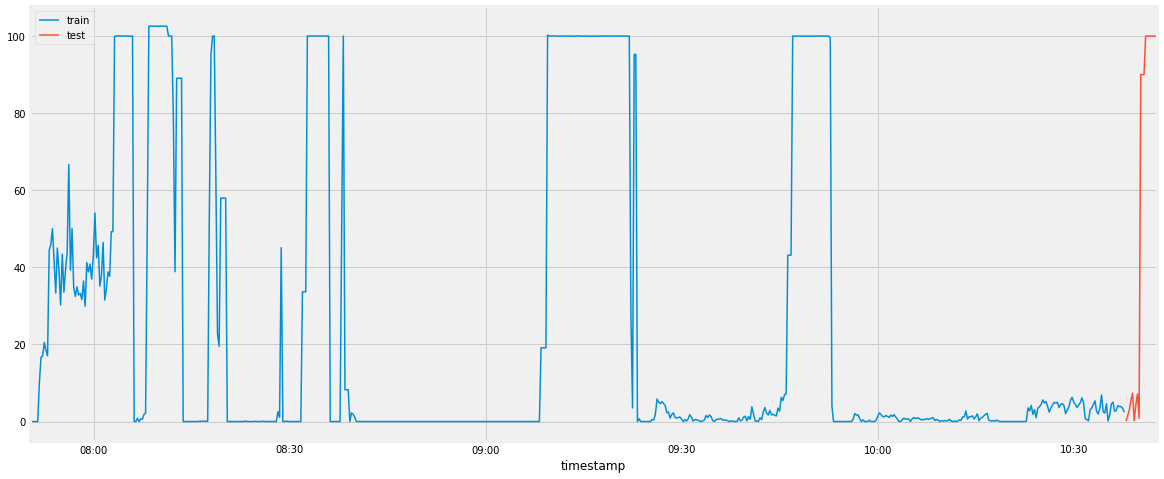

In [77]:
def minutes_to_step(min: int):
    lags = int((min * 60) / 15)
    print(lags, 'lags')
    return lags

steps = minutes_to_step(5) # 120 * 15seg = 30min
#steps = 8 # 8 * 15seg = 2min
data_train = req_dataframe[:-steps]
data_test  = req_dataframe[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(18, 8))
data_train['value'].plot(ax=ax, label='train')
data_test['value'].plot(ax=ax, label='test')
ax.legend()

40 lags
40 lags


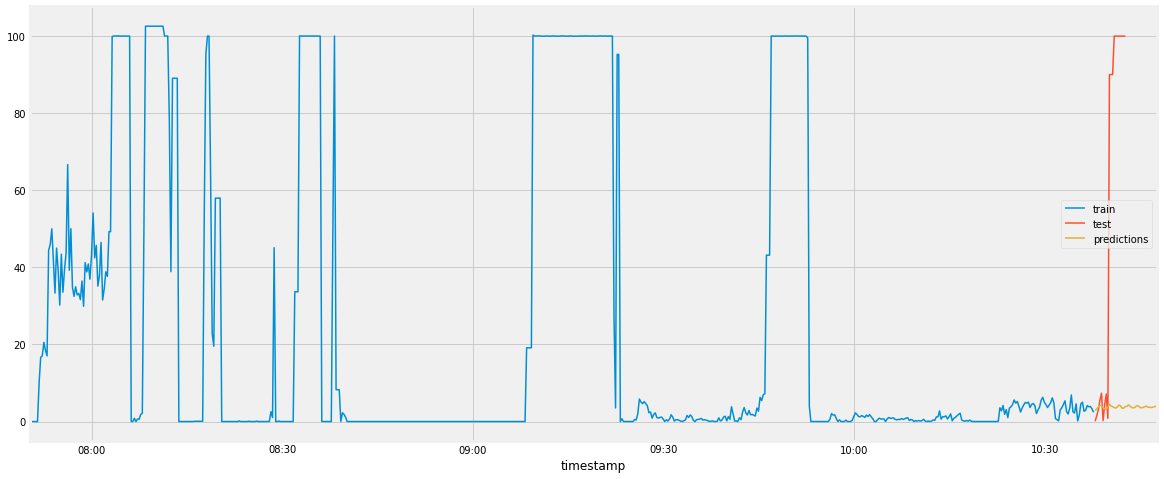

In [78]:
minutes = 10
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = minutes_to_step(minutes) # lags * 15seg = x min, para usar como predição
                )

forecaster.fit(y=data_train['value'])

#steps_prediction = 12 # 8 * 15seg = 2min
#steps_prediction = 120 # 120 * 15seg = 30min
steps_prediction = minutes_to_step(10) #steps
predictions = forecaster.predict(steps=steps_prediction)

fig, ax = plt.subplots(figsize=(18, 8))
data_train['value'].plot(ax=ax, label='train')
data_test['value'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [ ]:
error_mse = mean_squared_error(
                y_true = data_test['value'],
                y_pred = predictions
            )


print(f"Test error (mse): {error_mse}")

40 lags


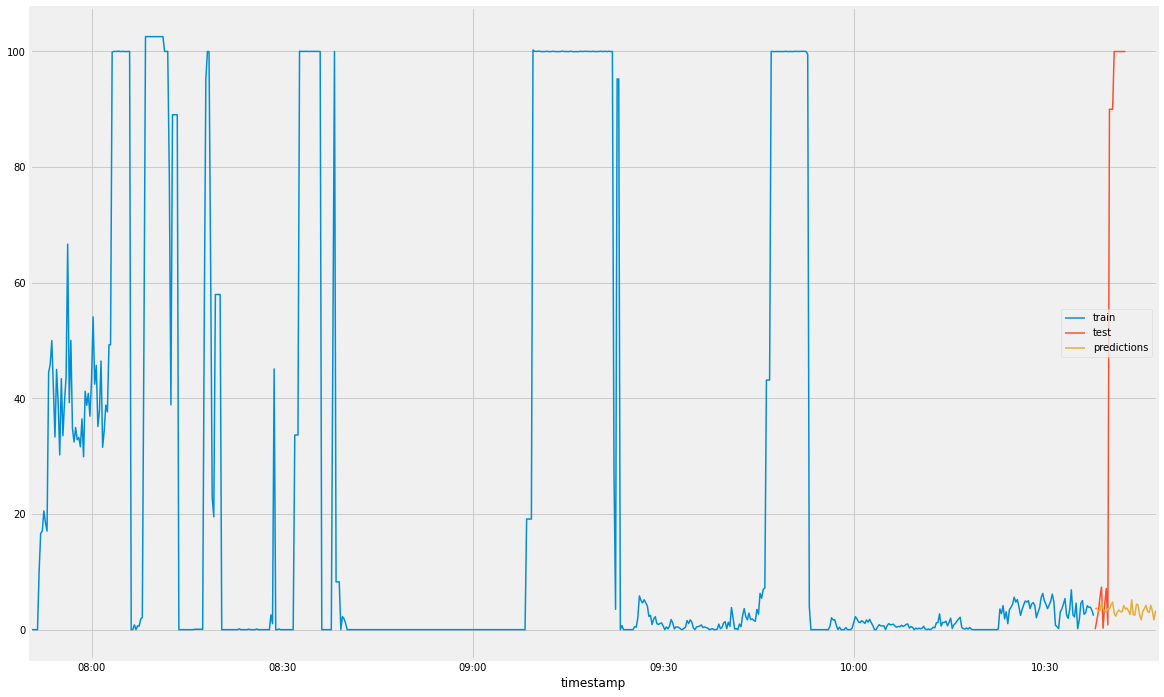

In [13]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================

regressor = RandomForestRegressor(
                max_depth    = 40,
                n_estimators = 3,
                random_state = 123,
                #criterion    = 'absolute_error',
                #max_features = 'sqrt'
            )

forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = minutes_to_step(minutes)
             )

forecaster.fit(y=data_train['value'])

# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps_prediction)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 12))
data_train['2022-05-07 16:12:34':]['value'].plot(ax=ax, label='train')
data_test['2022-05-07 16:12:34':]['value'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
yt = data_test['value']
yp = predictions

sc = StandardScaler()
scyt= sc.transform(yt)
scyt = sc.transform(yp)

error_mse = mean_squared_error(
                y_true = data_test['value'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

In [16]:
for i in range(len(data_test)):
    real = data_test.iloc[i]['value']
    data = data_test.iloc[i]['timestamp']
    previsto = predictions[i]
    print(f'Data: {data} | Real: {real} | Previsto: {previsto} | diff: {previsto - real}')

Data: 2022-05-11 10:37:57 | Real: 0.08 | Previsto: 3.58 | diff: 3.5
Data: 2022-05-11 10:38:12 | Real: 1.51 | Previsto: 3.733333333333333 | diff: 2.2233333333333327
Data: 2022-05-11 10:38:27 | Real: 3.08 | Previsto: 3.2300000000000004 | diff: 0.15000000000000036
Data: 2022-05-11 10:38:42 | Real: 5.59 | Previsto: 3.273333333333333 | diff: -2.316666666666667
Data: 2022-05-11 10:38:57 | Real: 7.36 | Previsto: 4.8500000000000005 | diff: -2.51
Data: 2022-05-11 10:39:12 | Real: 0.24 | Previsto: 3.58 | diff: 3.34
Data: 2022-05-11 10:39:27 | Real: 4.36 | Previsto: 3.16 | diff: -1.2000000000000002
Data: 2022-05-11 10:39:42 | Real: 7.14 | Previsto: 3.08 | diff: -4.06
Data: 2022-05-11 10:39:57 | Real: 0.82 | Previsto: 3.6300000000000003 | diff: 2.8100000000000005
Data: 2022-05-11 10:40:12 | Real: 90.0 | Previsto: 3.573333333333333 | diff: -86.42666666666666
Data: 2022-05-11 10:40:27 | Real: 90.0 | Previsto: 4.243333333333333 | diff: -85.75666666666666
Data: 2022-05-11 10:40:42 | Real: 90.0 | Previ

In [17]:
resultado = pd.DataFrame()

In [18]:
resultado['timestamp'] = data_test['timestamp']
resultado['req_failed_%_real'] = data_test['value']
resultado['req_failed_%_predicted'] = predictions
resultado['abs_difference_error'] = abs(resultado['req_failed_%_predicted'] - resultado['req_failed_%_real'])

In [19]:
resultado.head(len(resultado))

,timestamp,req_failed_%_real,req_failed_%_predicted,abs_difference_error
timestamp,,,,
2022-05-11 10:37:57,2022-05-11 10:37:57,0.08,3.580000,3.500000
2022-05-11 10:38:12,2022-05-11 10:38:12,1.51,3.733333,2.223333
2022-05-11 10:38:27,2022-05-11 10:38:27,3.08,3.230000,0.150000
2022-05-11 10:38:42,2022-05-11 10:38:42,5.59,3.273333,2.316667
2022-05-11 10:38:57,2022-05-11 10:38:57,7.36,4.850000,2.510000
2022-05-11 10:39:12,2022-05-11 10:39:12,0.24,3.580000,3.340000
2022-05-11 10:39:27,2022-05-11 10:39:27,4.36,3.160000,1.200000
2022-05-11 10:39:42,2022-05-11 10:39:42,7.14,3.080000,4.060000
2022-05-11 10:39:57,2022-05-11 10:39:57,0.82,3.630000,2.810000


In [20]:
resultado.describe()

,req_failed_%_real,req_failed_%_predicted,abs_difference_error
count,20.000000,20.000000,20.000000
mean,55.002000,3.510833,52.693500
std,48.087373,0.622801,46.777977
min,0.080000,2.330000,0.150000
25%,4.040000,3.093333,2.735000
50%,90.000000,3.483333,85.493333
75%,99.980000,3.655833,96.661667
max,100.000000,4.850000,97.650000
